In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import nibabel as nb
from scipy import io
from scipy import ndimage
import pandas as pd
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.data_simulation.transformation as transform
import CMR_HFpEF_Analysis.Image_utils as util

2023-02-08 16:46:28.979596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [85]:
def process(img,command):
    # command: z, x, y, T
    if command == 'z':
        img = img[:,:,[img.shape[-1] - i for i in range(1,img.shape[-1]+1)]]
    if command == 'x':
        img = img[[img.shape[0] - i for i in range(1,img.shape[0]+1)],:,:]
    if command == 'y':
        img = img[:,[img.shape[1] - i for i in range(1,img.shape[1]+1)],:]
    if command == 'T':
        for z in range(0,img.shape[-1]):
            img[:,:,z] = img[:,:,z].T
    return img

# Load a standard case (use 155)

(128, 128, 12) (1.25, 1.25, 10.0)
None


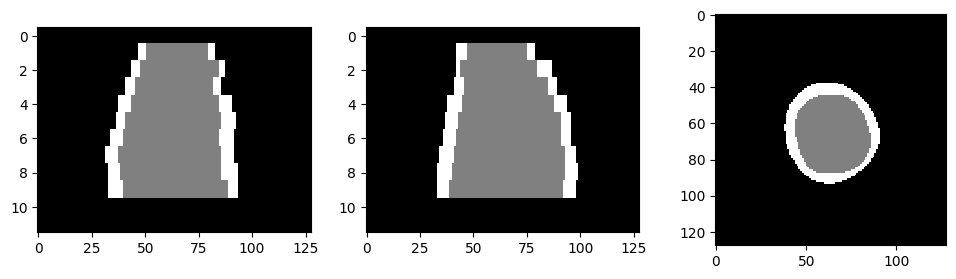

In [113]:
#filename = '/mnt/mount_zc_NAS/HFpEF/data/simulated_data_version2/155/ED/ds/data.nii.gz'
filename = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/nii-images/SC-HF-I-05/tf2/img_class_LR_processed.nii.gz'
img_file = nb.load(filename)
header = img_file.header
spacing = img_file.header.get_zooms()
affine = img_file.affine
img = img_file.get_fdata()
img= np.round(img)
img = img.astype(int)
print(img.shape,spacing)
plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(img[img.shape[0]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img[:,img.shape[1]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img[:,:,4], 'gray', aspect=spacing[0] / spacing[1])

# check orientation
a = util.correct_ori(img)
print(a)

# ii = util.relabel(img,4,0)
# nb.save(nb.Nifti1Image(ii, affine,header),'/mnt/mount_zc_NAS/HFpEF/data/simulated_data_new/d.nii.gz')

# Process Stony Brooks data

In [167]:
# find all the cases
filepath = '/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/Processed_Data'
case_list = ff.find_all_target_files(['SC-N-09/SAX/*.mat'],filepath)
print(case_list[0],case_list.shape)

process_list = pd.read_excel(os.path.join(os.path.dirname(filepath), 'Sunny_Brooks_proecessing.xlsx'))
print(process_list.shape)

/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks/Processed_Data/SC-N-09/SAX/SC-N-09_tf1.mat (2,)
(90, 13)


Do for all cases

In [168]:
for num in range(0,case_list.shape[0]):
    
    filename  = case_list[num]
    case_id = os.path.basename(os.path.dirname(os.path.dirname(filename)))
    tf = ff.find_timeframe(filename,1,'f')
    print(case_id, tf)
    row = process_list.loc[(process_list['case_id'] == case_id) & (process_list['tf'] == tf) ]
    row = row.iloc[0]
    print(row['case_id'], row['tf'])

    save_path= os.path.join('/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks','nii-images', case_id, 'tf'+str(tf))
    ff.make_folder([os.path.dirname(save_path), save_path])

    data = io.loadmat(filename)
    im_class = data['im_class']
    img_grey = data['Images']
    nb.save(nb.Nifti1Image(img_grey, affine, header=header), os.path.join(save_path,'img_greyscale.nii.gz'))
    nb.save(nb.Nifti1Image(im_class, affine, header=header), os.path.join(save_path,'img_class_LR.nii.gz'))

    # check whether it has both LV and myo
    if np.unique(im_class).shape[0] != 3:
        print('no both LV and myo; skip'); continue 
    if row['original_slice_num'] > 12:
        print('more than 12 slices, skip for now'); continue
    
    # crop and move
    img = util.crop_or_pad(im_class,[128,128,im_class.shape[-1]])
    img_grey = util.crop_or_pad(img_grey,[128,128,img_grey.shape[-1]])

    center_mass = util.center_of_mass(img,0,large = True)
    center_mass = [int(center_mass[0]),int(center_mass[1]),int(center_mass[2])]
    center_image = [ img.shape[i] // 2 for i in range(0,len(img.shape))]

    move = [ center_image[i] - center_mass[i] for i in range(0,len(center_mass))]
    img = util.move_3Dimage(img, [move[0],move[1],0])
    img_grey = util.move_3Dimage(img_grey, [move[0],move[1],0])

    # commands:
    img = process(img,row['step1']); img_grey = process(img_grey,row['step1'])
    img = process(img,row['step2']); img_grey = process(img_grey,row['step2'])
    img = process(img,row['step3']); img_grey = process(img_grey,row['step3'])
    img = process(img,row['step4']); img_grey = process(img_grey,row['step4'])

    # add slice num
    apex_num = row['apex_add_slice_num']
    img_final = np.zeros((img.shape[0],img.shape[1],12))
    img_final[:,:, apex_num: apex_num + img.shape[-1]] = img

    img_grey_final = np.zeros((img.shape[0],img.shape[1],12)) - np.min(img_grey)
    img_grey_final[:,:, apex_num: apex_num + img_grey.shape[-1]] = img_grey

    # flip
    img_final_flip = img_final[:,:,[img_final.shape[-1] - i for i in range(1,img_final.shape[-1] + 1)]]
    img_grey_final_flip = img_grey_final[:,:,[img_grey_final.shape[-1] - i for i in range(1,img_grey_final.shape[-1] + 1)]]

    # save process parameters
    np.save(os.path.join(save_path,'process_move.npy'), np.array([move[0], move[1],0]))
    # np.save(os.path.join(save_path,'process_rev.npy'), np.array([x_rev, y_rev, z_rev]))
    np.save(os.path.join(save_path,'process_addslice.npy'), np.array([apex_num, 12 - apex_num - img.shape[-1]]))

    # save 
    nb.save(nb.Nifti1Image(img_final, affine, header=header), os.path.join(save_path,'img_class_LR_processed.nii.gz'))
    nb.save(nb.Nifti1Image(img_grey_final, affine, header=header), os.path.join(save_path,'img_greyscale_processed.nii.gz'))
    nb.save(nb.Nifti1Image(img_final_flip, affine, header=header), os.path.join(save_path,'img_class_LR_processed_flip.nii.gz'))
    nb.save(nb.Nifti1Image(img_grey_final_flip, affine, header=header), os.path.join(save_path,'img_greyscale_processed_flip.nii.gz'))



SC-N-09 1
SC-N-09 1
SC-N-09 2
SC-N-09 2
no both LV and myo; skip


do for each case separately

In [90]:
num = 1
filename  = case_list[num]
case_id = os.path.basename(os.path.dirname(os.path.dirname(filename)))
tf = ff.find_timeframe(filename,1,'f')
print(case_id, tf)
data = io.loadmat(filename)
im_class = data['im_class']
im_grey_raw = data['Images']
print(im_class.shape)

# check whether it has both LV and myo
classes = np.unique(im_class)
if classes.shape[0] == 3:
    print(classes, 'both LV and myo')
else:
    print(classes)

SC-HF-I-04 2
(256, 256, 10)
[0 1 2] both LV and myo


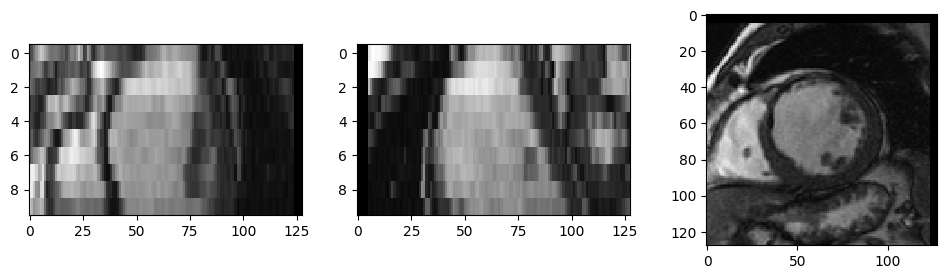

In [98]:
# crop and pad
img = util.crop_or_pad(im_class,[128,128,im_class.shape[-1]])
im_grey = util.crop_or_pad(im_grey_raw,[128,128,im_grey_raw.shape[-1]])

# move
center_mass = util.center_of_mass(img,0,large = True)
center_mass = [int(center_mass[0]),int(center_mass[1]),int(center_mass[2])]
center_image = [ img.shape[i] // 2 for i in range(0,len(img.shape))]

move = [ center_image[i] - center_mass[i] for i in range(0,len(center_mass))]
img = util.move_3Dimage(img, [move[0],move[1],0])
im_grey = util.move_3Dimage(im_grey, [move[0],move[1],0])

# transform
# for z in range(0,img.shape[-1]):
#     img[:,:,z] = img[:,:,z].T
# for z in range(0,im_grey.shape[-1]):
#     im_grey[:,:,z] = im_grey[:,:,z].T

# flip z
img = img[:,:,[img.shape[-1] - i for i in range(1,img.shape[-1]+1)]]
im_grey = im_grey[:,:,[im_grey.shape[-1] - i for i in range(1,im_grey.shape[-1]+1)]]


plt.figure(figsize = (12,3))
img_show = np.copy(im_grey)
plt.subplot(131); plt.imshow(img_show[56, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img_show[:,64, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img_show[:,:,6], 'gray', aspect=spacing[0] / spacing[1])



1


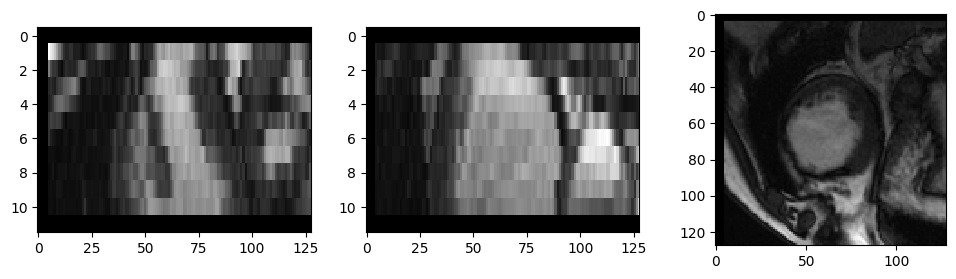

In [96]:
# flip x
img = img[[img.shape[0] - i for i in range(1,img.shape[0]+1)],:,:]
im_grey = im_grey[[im_grey.shape[0] - i for i in range(1,im_grey.shape[0]+1)],:,:]

# flip y
# img = img[:,[img.shape[1] - i for i in range(1,img.shape[1]+1)],:]
# im_grey = im_grey[:,[im_grey.shape[1] - i for i in range(1,im_grey.shape[1]+1)],:]



# add slices to make z-axis number = 12
add_slice_num = 12 - img.shape[-1]
apex_num = add_slice_num // 2
print(apex_num)
img_final = np.zeros((img.shape[0],img.shape[1],12))
img_final[:,:, apex_num: apex_num + img.shape[-1]] = img

im_grey_final = np.zeros((im_grey.shape[0],im_grey.shape[1],12))
im_grey_final[:,:, apex_num: apex_num + im_grey.shape[-1]] = im_grey

plt.figure(figsize = (12,3))
img_show = np.copy(im_grey_final)
plt.subplot(131); plt.imshow(img_show[50, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img_show[:,64, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img_show[:,:,4], 'gray', aspect=spacing[0] / spacing[1])

In [427]:
save_path= os.path.join('/mnt/mount_zc_NAS/HFpEF/data/Sunny_Brooks','nii-images', case_id, 'tf'+str(tf))
ff.make_folder([os.path.dirname(save_path), save_path])
img_nb = nb.Nifti1Image(img_final, affine, header=header)
nb.save(img_nb, os.path.join(save_path,'img_LR.nii.gz'))
